In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("./../")

In [82]:
from pathlib import Path
import math
import pickle
#
import torch
import torchvision
from torchvision import utils
import torchvision.transforms as T
#
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
#
from misc.plot_utils import plot_mat, imshow
from effcn.models_smallnorb import SmallNorbEffCapsNet
from effcn.functions import create_margin_loss
from effcn.utils import count_parameters
from datasets.smallnorb import SmallNORB
from effcn.functions import masking

### Preprocessing

In [4]:
device = torch.device("cuda")
device

device(type='cuda')

In [6]:
p_experiment = "/mnt/data/experiments/EfficientCN/smallnorb/effcn_smallnorb_2021_12_19_03_12_57"
p_experiment = Path(p_experiment)
p_config = p_experiment / "config.pkl"
p_stats = p_experiment / "stats.pkl"
p_ckpts = p_experiment / "ckpts"
with open(p_config, "rb") as file:
    config = pickle.load(file)
with open(p_stats, "rb") as file:
    stats = pickle.load(file)
#
p_data = config.paths.data
p_model = p_ckpts / config.names.model_file.format(200)
p_model.exists()

True

In [7]:
config.paths.data = '/mnt/data/datasets/smallnorb'
config.paths.data

config.names.model_file.format(200)

'model_200.ckpt'

In [8]:
model = SmallNorbEffCapsNet()
model.load_state_dict(torch.load(p_model))
model = model.to(device)
model.eval()

SmallNorbEffCapsNet(
  (backbone): SmallNorbEcnBackbone(
    (layers): Sequential(
      (0): Conv2d(2, 32, kernel_size=(7, 7), stride=(2, 2), padding=valid)
      (1): LeakyReLU(negative_slope=0.3, inplace=True)
      (2): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
      (4): LeakyReLU(negative_slope=0.3, inplace=True)
      (5): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
      (7): LeakyReLU(negative_slope=0.3, inplace=True)
      (8): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=valid)
      (10): LeakyReLU(negative_slope=0.3, inplace=True)
      (11): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    )


In [60]:
#Tranformations
transform_train = T.Compose([
    T.Resize(64),
    T.CenterCrop(48),
    T.Normalize(mean=[191.7811/255,193.0594/255,0],std=[45.2232/255, 44.2558/255,1]),
])
transform_valid = T.Compose([
    T.Resize(64),
    T.CenterCrop(48),        
    T.Normalize(mean=[191.0684/255,192.0952/255,0],std=[45.4354/255, 44.3388/255,1]),        
])

In [61]:
    ds_train = SmallNORB(root=p_data,train=True, download=True, transform=transform_train, mode="pseudo")
    ds_valid = SmallNORB(root=p_data,train=False, download=True, transform=transform_valid, mode="pseudo")
  

In [155]:
idx = 0

print(len(ds_train.data))


x,y,_ = ds_train[idx]

x = torch.unsqueeze(x,dim=0)
y = torch.unsqueeze(y,dim=0)

print(x.size())
print(y.size(), y)

24300
torch.Size([1, 2, 48, 48])
torch.Size([1]) tensor([0])


### Generate Capsuls for influenced Reconstruction

In [205]:
x = x.to(device)
y = y.to(device)

uh, _ = model.forward(x, y)

In [80]:
print(uh.size())

torch.Size([1, 5, 16])


In [83]:
m_uh = masking(uh)
x_rec = model.decoder(m_uh)

In [98]:
def imshow(img, cmap="gray", vmin=None, vmax=None):
    npimg = img.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap=cmap, vmin=None, vmax=None)
    plt.show()

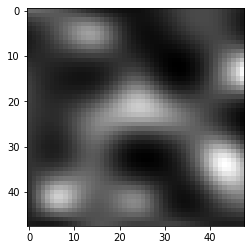

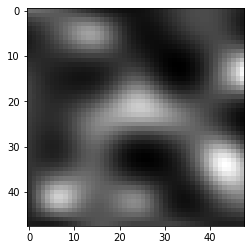

In [108]:
imshow(torch.squeeze(x_rec[:,1:2,:,:],dim=0))
imshow(torch.squeeze(x_rec[:,0:1,:,:],dim=0))

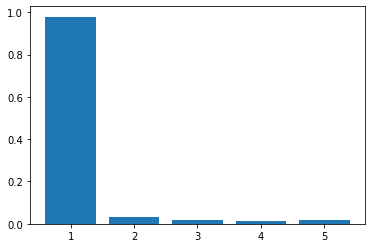

tensor([-0.2609,  0.1872,  0.2466,  0.2395, -0.2275,  0.2753,  0.2738, -0.1998,
         0.2714,  0.2098, -0.1809, -0.1274,  0.3131, -0.2779, -0.3019,  0.2477],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([-0.2609,  0.1872,  0.2466,  0.2395, -0.2275,  0.2753,  0.2738, -0.1998,
         0.2714,  0.2098, -0.1809,  0.8726,  0.3131, -0.2779, -0.3019,  0.2477],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([-0.2227,  0.2287,  0.2349,  0.2855, -0.2384,  0.2854,  0.2494, -0.1704,
         0.3154,  0.1732, -0.1374, -0.1180,  0.3501, -0.2712, -0.2778,  0.2406],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


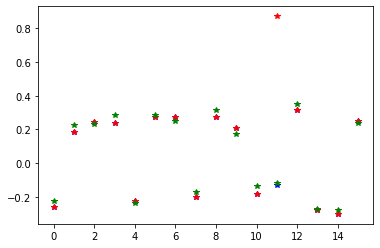

torch.Size([3, 5, 16])

In [289]:
torch.argmax(uh,dim=2)

sq_uh = torch.squeeze(uh,dim=0)
a = torch.norm(sq_uh, dim=1)
plt.bar(np.arange(1,6,1), a.detach().cpu().numpy())
plt.show()

i_cap = torch.argmax(torch.norm(uh, dim=2))
ref = uh[:,i_cap,:]

uh_delta = uh.clone()
uh_delta[:,i_cap,:] += torch.tensor([0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0]).to(device)
delta = uh_delta[:,i_cap,:]

torch.manual_seed(42)
uh_delta2 = uh.clone()
uh_delta2[:,i_cap,:] += (torch.rand(16).to(device)-0.5) * 0.1
delta2 = uh_delta2[:,i_cap,:]

print(torch.squeeze(ref,dim=0))
plt.plot(torch.squeeze(ref,dim=0).detach().cpu().numpy(),"b*")
print(torch.squeeze(delta,dim=0))
plt.plot(torch.squeeze(delta,dim=0).detach().cpu().numpy(),"r*")
print(torch.squeeze(delta2,dim=0))
plt.plot(torch.squeeze(delta2,dim=0).detach().cpu().numpy(),"g*")
plt.show()



uh_n = torch.cat((uh, uh_delta, uh_delta2), dim=0)  

uh_n.size()

#print(uh_delta-uh)

In [290]:
m_uh_n = masking(uh_n)
x_rec_n = model.decoder(m_uh_n)

torch.Size([3, 2, 48, 48])


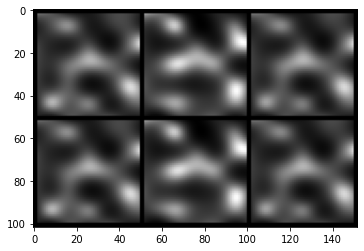

In [291]:
print(x_rec_n.size())
rec = x_rec_n.cpu()
scal = lambda x: (x-x.min())/(x.max()-x.min())
img = torchvision.utils.make_grid(torch.cat([scal(rec[:,0:1,:,:]),scal(rec[:,1:2,:,:])], dim=0), nrow=rec.shape[0])
plt.imshow(img.permute(1,2,0))
plt.show()

### Prepare affine transformations embedding

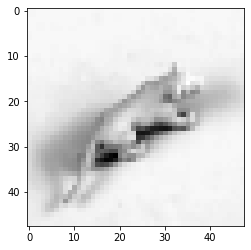

In [318]:
x_aff = T.functional.affine(img=x, angle=0, translate=[0,0], scale=1.,shear=0)

#imshow(torch.squeeze(x[:,1:2,:,:],dim=0))
imshow(torch.squeeze(x_aff[:,1:2,:,:],dim=0))